# Experiment outline

##  The ultimate goal of this experiment

* Identify the genes going up between N2_EV and sams-1(lof)_EV `run_NE-ABC_vs_SE-ABC_up.csv`
* Ask which of these genes drops out in the sams-1(lof)_let-607 `run_NL-ABC_vs_SL-ABC_up.csv`
* And which of these genes drops out in the sams-1(lof))_xbp-1. `run_NX-ABC_vs_SX-ABC_up.csv`
 
 ## The expected deseq experiment runs

That data will be revealed by generating three sets of deseq: 
* N2_EV vs sams-1(lof) EV, 
* N2_let-607 vs sams-1(let-607)
* N2_xbp-1 vs sams-1(lof)_xbp-1.  


We can then make an excel chart with the fold changes.  
This data will also be important to interpret in a numerical way, so we should look at the numbers before we decide on cutoffs. 
 
## Confirmation of results 
As a reality check, we should also look at the individual effects of the knockdowns: 
* N2_EV vs N2_let-607 (should be similar to the last RNA seq we did) 
* N2_EV vs N2_xbp-1 (published data here which I can find)
 
## Notes
* My preference is to use #1 method to compare gene sets in this type of experiment, as it takes into account genes changes by each of the RNAis in wild type animals.  

* Many times genes have one regulatory pattern in basal conditions and a distinct one when stressed and if we do it the first way, those effects will be accounted for.  

* However, we could also do comparisons within the genotype (each N2 RNAi to N2_EV and each sams-1 RNAi to sams-1(lof)_EV. 

* If we can do three sets by deseq, this could be useful, but I would wait on this until we’ve looked the data from #1 and #2 and I’m guessing we would use the data from #1 and #2.
 


In [1]:
# R cell
%load_ext rpy2.ipython

In [4]:
import pandas as pd
from rpy2.robjects import pandas2ri, r

# Activate the pandas2ri conversion
pandas2ri.activate()


## R Code to create the foldChage UP files

* This is reworksed code from the DESeq pipelin

In [2]:
%%R
# Create the UP and DOWN expression files using the foldChange cutoff technique used in DEBrowser
# This will give consistent results with the DESeq pipeline

suppressPackageStartupMessages({
    library(dplyr)
})


filter_and_save_csv <- function(alldetected, foldChange_cutoff, padj_cutoff, direction_change, output_csv_file) {
   
  # Filter rows based on the specified conditions
  if (direction_change == "DOWN") {
    filtered_df <- subset(alldetected, foldChange <= 1 / foldChange_cutoff & padj <= padj_cutoff)
  } else if (direction_change == "UP") {
    filtered_df <- subset(alldetected, foldChange >= foldChange_cutoff & padj <= padj_cutoff)
  } else {
    stop("Invalid direction_change value. Use 'UP' or 'DOWN'.")
  }
  
  # Write the filtered data frame to a new CSV file
  write.csv(filtered_df, file = output_csv_file, row.names = FALSE)
  
  return(output_csv_file)
}

filter_and_save_experiment <- function(input_counts_file, foldChange_cutoff, padj_cutoff){
   file_extension <- sub(".+\\.(\\w+)$", "\\1", input_counts_file)
   sep <- switch(file_extension, csv = ",", tsv = "\t", NULL)
   counts_data <- read.table(input_counts_file, header = TRUE, sep = sep)

   # Create UP DOWN Gene Sets for WormCat
   #direction_changes <- c("UP", "DOWN")
     direction_changes <- c("UP")

   for (direction_change in direction_changes) {
       output_csv_file <- sub("alldetected", tolower(direction_change), input_counts_file)
       filter_and_save_csv(counts_data, foldChange_cutoff, padj_cutoff, direction_change, output_csv_file)
   }
}


In [3]:
%%R
#####################################################################
# Set the desired foldChange cutoff and the all detected files to use
foldChange_cutoff <- 2.0
padj_cutoff <- 0.01

experiments <- c("data/run_NE-ABC_vs_SE-ABC_alldetected.csv", 
                 "data/run_NL-ABC_vs_SL-ABC_alldetected.csv", 
                 "data/run_NX-ABC_vs_SX-ABC_alldetected.csv")
for (experiment in experiments) {
    filter_and_save_experiment(experiment, foldChange_cutoff, padj_cutoff)
}


## Venn Diagrams 

* look at wether the set of xbp-1 or let-607 dependent genes are changed a little (2-3 fold) or a lot (5-10 fold).

In [5]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

In [7]:
# Load the CSV files into dataframes
ne_se_df = pd.read_csv('data/run_NE-ABC_vs_SE-ABC_up.csv')
nl_sl_df = pd.read_csv('data/run_NL-ABC_vs_SL-ABC_up.csv')
nx_sx_df = pd.read_csv('data/run_NX-ABC_vs_SX-ABC_up.csv')
print(f"{len(ne_se_df)} expect 3290 | {len(nl_sl_df)} expect 2731 | {len(nx_sx_df)} expect 2923")

# Extract the IDs
ne_se_ids = set(ne_se_df['ID'])
nl_sl_2fc_ids = set(nl_sl_df['ID'])
nl_sl_5fc_ids = set(nl_sl_df[nl_sl_df['foldChange'] >= 5]['ID'])
nx_sx_2fc_ids = set(nx_sx_df['ID'])
nx_sx_5fc_ids = set(nx_sx_df[nx_sx_df['foldChange'] >= 5]['ID'])

3290 expect 3290 | 2731 expect 2731 | 3923 expect 2923


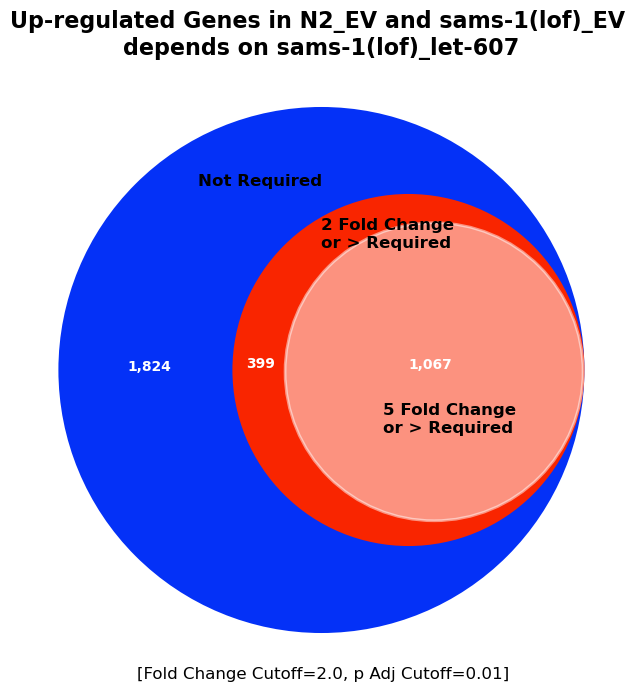

In [89]:
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

# Create a Venn diagram
plt.close('all')
plt.figure(figsize=(8, 8))

region1 = ne_se_ids
region2 = ne_se_ids & nl_sl_2fc_ids
region3 = ne_se_ids & nl_sl_2fc_ids & nl_sl_5fc_ids

# Create a Venn diagram with the modified sets
venn = venn3(subsets=(region1, region2, region3), set_labels=('', '', ''))

c = venn3_circles(subsets=(region1, region2, region3))
c[0].set_color('#0431f7')
c[1].set_color('#f92500')
c[2].set_color('white')
c[2].set_alpha(0.5)

region1_label = venn.get_label_by_id('100')
region1_label.set(text=f"{int(region1_label.get_text()):,}", color='white', fontweight='bold')


region2_label = venn.get_label_by_id('110')
region2_label.set(text=f"{int(region2_label.get_text()):,}", color='white', fontweight='bold')
#region2_label.set_color('white')

region3_label = venn.get_label_by_id('111')
region3_label.set(text=f"{int(region3_label.get_text()):,}", color='white', fontweight='bold')
region3_label.set_position((region3_label.get_position()[0] + 0.3, region3_label.get_position()[1]))


plt.text(0.3, 0.8, "Not Required", fontsize=12, fontweight='bold', color='black',  transform=plt.gca().transAxes)
plt.text(0.5, 0.7, "2 Fold Change \nor > Required", fontsize=12, fontweight='bold', color='black', transform=plt.gca().transAxes)
plt.text(0.6, 0.4, "5 Fold Change \nor > Required", fontsize=12, fontweight='bold',color='black', transform=plt.gca().transAxes)
plt.text(0.2, 0.0, "[Fold Change Cutoff=2.0, p Adj Cutoff=0.01]", fontsize=12, color='black',  transform=plt.gca().transAxes)
            
plt.title("Up-regulated Genes in N2_EV and sams-1(lof)_EV \ndepends on sams-1(lof)_let-607",fontsize=16, fontweight='bold')
plt.savefig('data/venn_overlap_NE-SE_vs_NL_SL_up.png')
plt.show()

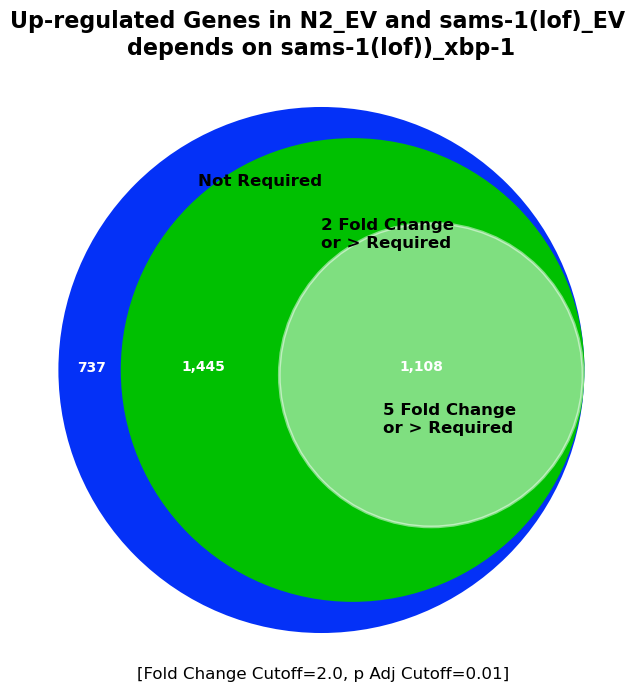

In [90]:
import pandas as pd
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

# Create a Venn diagram
plt.close('all')
plt.figure(figsize=(8, 8))

region1 = ne_se_ids
region2 = ne_se_ids & nx_sx_2fc_ids
region3 = ne_se_ids & nx_sx_2fc_ids & nx_sx_5fc_ids

# Create a Venn diagram with the modified sets
venn = venn3(subsets=(region1, region2, region3), set_labels=('', '', ''))

c = venn3_circles(subsets=(region1, region2, region3))
c[0].set_color('#0431f7')
c[1].set_color('#00c001')
c[2].set_color('white')
c[2].set_alpha(0.5)

region1_label = venn.get_label_by_id('100')
region1_label.set(text=f"{int(region1_label.get_text()):,}", color='white', fontweight='bold')


region2_label = venn.get_label_by_id('110')
region2_label.set(text=f"{int(region2_label.get_text()):,}", color='white', fontweight='bold')
#region2_label.set_color('white')

region3_label = venn.get_label_by_id('111')
region3_label.set(text=f"{int(region3_label.get_text()):,}", color='white', fontweight='bold')
region3_label.set_position((region3_label.get_position()[0] + 0.3, region3_label.get_position()[1]))


plt.text(0.3, 0.8, "Not Required", fontsize=12, fontweight='bold', color='black',  transform=plt.gca().transAxes)
plt.text(0.5, 0.7, "2 Fold Change \nor > Required", fontsize=12, fontweight='bold', color='black', transform=plt.gca().transAxes)
plt.text(0.6, 0.4, "5 Fold Change \nor > Required", fontsize=12, fontweight='bold',color='black', transform=plt.gca().transAxes)
plt.text(0.2, 0.0, "[Fold Change Cutoff=2.0, p Adj Cutoff=0.01]", fontsize=12, color='black',  transform=plt.gca().transAxes)
            
plt.title("Up-regulated Genes in N2_EV and sams-1(lof)_EV \ndepends on sams-1(lof))_xbp-1",fontsize=16, fontweight='bold')
plt.savefig('data/venn_overlap_NE-SE_vs_NX_SX_up.png')
plt.show()

# Save the results to a consolidated CSV file

In [91]:
# Building the results dataframe
results_df = ne_se_df

# Get the nl_sl_2fc genes that overlap with ne_se
nl_sl_2fc_overlap_df = pd.DataFrame(list(ne_se_ids & nl_sl_2fc_ids), columns=['ID'])

# Add boolean column NL_SL
results_df['NL_SL']= results_df['ID'].isin(nl_sl_2fc_overlap_df['ID'])

# Add boolean column NL_SL to original nl_sl_df (Temparary needed so we can filter)
nl_sl_df['NL_SL'] = nl_sl_df['ID'].isin(nl_sl_2fc_overlap_df['ID'])
print(nl_sl_df['NL_SL'].value_counts())

# Get only the Genes we are interested in
filtered_nl_sl_df = nl_sl_df[nl_sl_df['NL_SL']==True]
print(filtered_nl_sl_df['NL_SL'].value_counts())
print(len(filtered_nl_sl_df))


# OK Now we need to get the foldChange for these Genes into the results_df with a unique name
filtered_nl_sl_df = filtered_nl_sl_df.rename(columns={'foldChange': 'NL_SL_foldChange'})
results_df = results_df.merge(filtered_nl_sl_df[['ID', 'NL_SL_foldChange']], on='ID', how='left')

# OK Now we need to get the padj for these Genes into the results_df with a unique name
filtered_nl_sl_df = filtered_nl_sl_df.rename(columns={'padj': 'NL_SL_padj'})
results_df = results_df.merge(filtered_nl_sl_df[['ID', 'NL_SL_padj']], on='ID', how='left')


results_df.to_csv('data/FoldCahnge-for-NE_SE-NX_SX-NL_SL.csv', index=False)

True     1466
False    1265
Name: NL_SL, dtype: int64
True    1466
Name: NL_SL, dtype: int64
1466


In [92]:
# Now we do the same for NX_SX

nx_sx_2fc_overlap_df = pd.DataFrame(list(ne_se_ids & nx_sx_2fc_ids), columns=['ID'])

results_df['NX_SX']= results_df['ID'].isin(nx_sx_2fc_overlap_df['ID'])
nx_sx_df['NX_SX'] = nx_sx_df['ID'].isin(nx_sx_2fc_overlap_df['ID'])

# Add foldChange for NX_SX
filtered_nx_sx_df = nx_sx_df[nx_sx_df['NX_SX']]
filtered_nx_sx_df = filtered_nx_sx_df.rename(columns={'foldChange': 'NX_SX_foldChange'})
results_df = results_df.merge(filtered_nx_sx_df[['ID', 'NX_SX_foldChange']], on='ID', how='left')

# Add padj for NX_SX
filtered_nx_sx_df = filtered_nx_sx_df.rename(columns={'padj': 'NX_SX_padj'})
results_df = results_df.merge(filtered_nx_sx_df[['ID', 'NX_SX_padj']], on='ID', how='left')

results_df.to_csv('data/FoldCahnge-for-NE_SE-NX_SX-NL_SL.csv', index=False)

## Appendix

In [10]:
plt.figure(figsize=(8, 8))
# Calculate the sets needed for the Venn diagram
only_in_ids1 = ids1 - ids3
in_both = ids1 & ids3

# Create a Venn diagram with the modified sets
plt.figure(figsize=(8, 8))
venn = venn2([only_in_ids1 | in_both, in_both], ('No Dependency on sams-1(lof))_xbp-1', 'Depends on sams-1(lof))_xbp-1'))
venn.get_label_by_id('01').set_text('')

plt.title("Up-regulated Genes in N2_EV and sams-1(lof)_EV \n(foldChange_cutoff=2.0, padj_cutoff=0.01)")
plt.savefig('data/ven_unique_NE-SE_vs_NX_SX_up.png')
plt.show()


in_both_NX_SX_df = pd.DataFrame(list(in_both), columns=['ID'])
in_both_NX_SX_df


NameError: name 'ids1' is not defined

<Figure size 800x800 with 0 Axes>

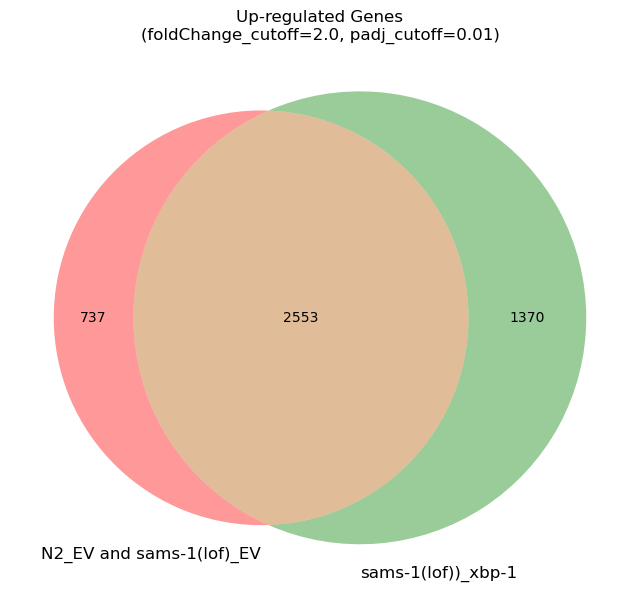

737


<Figure size 640x480 with 0 Axes>

In [55]:
# Create a Venn diagram
plt.figure(figsize=(8, 8))
venn2([ids1, ids3], ('N2_EV and sams-1(lof)_EV', 'sams-1(lof))_xbp-1'))
plt.title("Up-regulated Genes\n(foldChange_cutoff=2.0, padj_cutoff=0.01)")
#plt.savefig('data/venn_diagram_upregulated_genes.png')
plt.show()

# List the genes that are in df1 but not in df2
unique_to_df1 = ids1 - ids3

unique_df = pd.DataFrame(list(unique_to_df1), columns=['ID'])
unique_df.to_csv('data/unique_NE-SE_vs_NX_SX_up.csv', index=False)
print(len(unique_df))

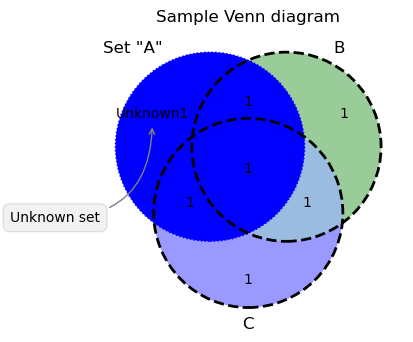

In [39]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
plt.figure(figsize=(4,4))
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('A', 'B', 'C'))
v.get_patch_by_id('100').set_alpha(1.0)
v.get_patch_by_id('100').set_color('white')
v.get_label_by_id('100').set_text('Unknown1')
v.get_label_by_id('A').set_text('Set "A"')
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
c[0].set_lw(1.0)
c[0].set_color('blue')
c[0].set_ls('dotted')
plt.title("Sample Venn diagram")
plt.annotate('Unknown set', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show()